# DM2 Probabilistic graphical models

In [13]:
import scipy.stats as sct
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


x = np.loadtxt("EMGaussian.data")
xtest = np.loadtxt("EMGaussian.test")

In [14]:
def ell(sigma, centres): #On défini une fonction qui trace les ellipses de confiance
    vals, vecs = np.linalg.eigh(sigma)
    vals = vals[vals.argsort()[::-1]]
    vecs = vecs[:, vals.argsort()[::-1]]
    
    axe = plt.gca()
    
    ellip = Ellipse(centres, 2*np.sqrt(vals[1]*4.61), 2*np.sqrt(vals[0]*4.61),\
                    angle= np.degrees(np.arctan(vecs[0, 1]/vecs[0, 0])), Fill=False)
    axe.add_artist(ellip)
    
def ell2(centres, sigma): #Equivalent de ell mais dans le cas où les ellipses sont des cercles 
    axe = plt.gca()
    
    ellip = Ellipse(centres, 2*np.sqrt(sigma*4.61), 2*np.sqrt(sigma*4.61), Fill=False)
    axe.add_artist(ellip)

In [15]:
k = 4 #Fixé

## K-means

In [16]:
def kmeans(x, k):
    n, p = x.shape
    
    init = np.random.randint(0,n, size=k) #Séléction aléatoire des points de départ
    moyennes = x[init][0:]
    
    
    distortion = 0
    distortions = []
    newdistortion = 10


    while abs(distortion - newdistortion) > 1e-10: #On s'arrête quand la distorsion n'évolue plus assez
        newdistortion = distortion

        
        
        matrice = np.repeat(x, k, axis = 0) #On répète k fois x
        matricemoyennes = np.tile(moyennes, (n,1)) #On répète chaque moyenne k fois
        
        m = matrice - matricemoyennes #on calcule x_{i} - mu_{k}
        m = np.linalg.norm(m, axis=1).reshape(n*k,1)#On calcule la norme de x - mu
        #L'intérêt de calculer les normes de x_{i}-mu_{k} de cette manière
        #est d'éviter les boucles for et donc de perdre temps de calcul.
        
        classes = []
        for i in range(0, n*k, k):
        #On assigne à x_{i} la classe associée au mu_{k} qui lui est le plus proche
            classes.append(np.argmin(m[i:i+k])) 
        
        classes = np.array(classes)
        for i in range(k):
            moyennes[i] = np.mean(x[classes == i], axis=0) #On met à jour les mu_{k} à l'aide des classes trouvées
        
        
        
        #On calcule la nouvelle distortion
        distortion = newdistortion 
        distortion = 0
        distortion = sum([np.sum(np.linalg.norm(x[classes == i] - moyennes[i], axis=1)) for i in range(k)])

        distortions.append(distortion)

    

    return moyennes, classes, distortions, x[init][0:]


Initialisation #0
La distorsion vaut:1103.9226924970349
Les centroïds finaux valent: 
 [[-3.72020481 -4.1849974 ]
 [ 3.78809286  4.99905357]
 [ 3.57429183 -2.880828  ]
 [-2.14180002  3.97338429]]


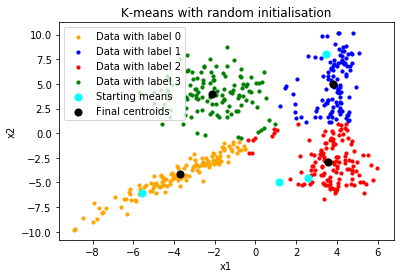

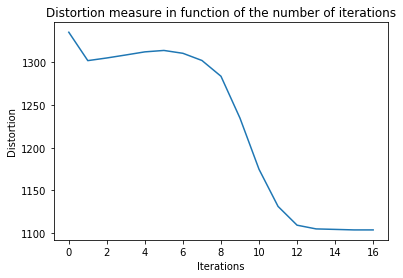

Initialisation #1
La distorsion vaut:1109.4166282170168
Les centroïds finaux valent: 
 [[-3.81879354 -4.27423441]
 [ 3.80280826  5.10467248]
 [ 3.33557966 -2.644529  ]
 [-2.24034752  4.12744772]]


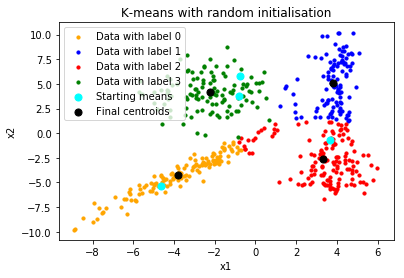

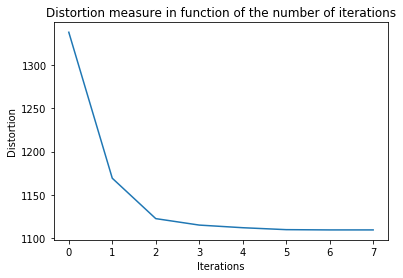

Initialisation #2
La distorsion vaut:1109.416628217017
Les centroïds finaux valent: 
 [[ 3.80280826  5.10467248]
 [ 3.33557966 -2.644529  ]
 [-3.81879354 -4.27423441]
 [-2.24034752  4.12744772]]


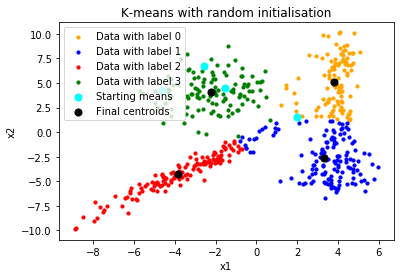

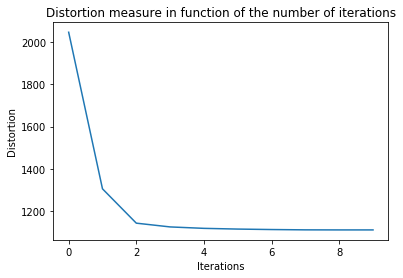

Initialisation #3
La distorsion vaut:1102.5458611063004
Les centroïds finaux valent: 
 [[ 3.60401871 -2.88772669]
 [-2.1554649   4.11299388]
 [ 3.78809286  4.99905357]
 [-3.6366214  -4.05302194]]


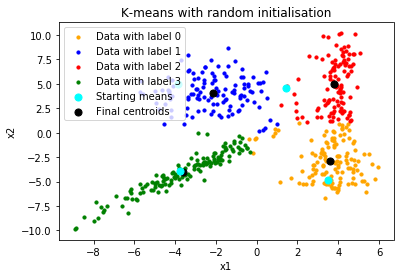

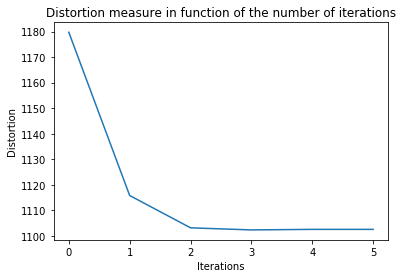

Initialisation #4
La distorsion vaut:1108.4646065085099
Les centroïds finaux valent: 
 [[ 3.80280826  5.10467248]
 [ 3.36449672 -2.65646983]
 [-3.78479953 -4.21639713]
 [-2.23856221  4.16339661]]


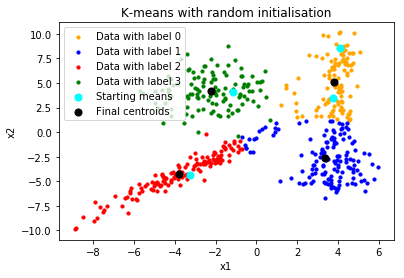

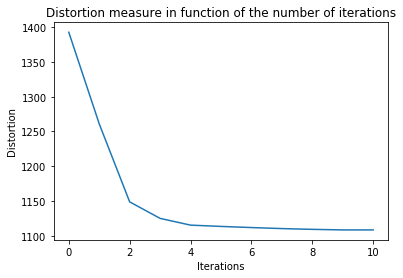

In [17]:
for i in range(5):
    print("Initialisation #{}".format(i))
    moyennes, classes, distortion, depart = kmeans(x,k)
    print("La distorsion vaut:{}".format(distortion[-1]))
    print("Les centroïds finaux valent: \n {}".format(moyennes))
    
   
    #On plot les points, et les centroïds finaux
    a = plt.scatter(x[classes == 0][0:,0],\
                    x[classes == 0][0:,1], color="orange", s=10)
    
    b = plt.scatter(x[classes == 1][0:,0],\
                    x[classes == 1][0:,1], color="blue", s=10)

    c = plt.scatter(x[classes == 2][0:,0],\
                    x[classes == 2][0:,1], color="red", s=10)
    
    d = plt.scatter(x[classes == 3][0:,0],\
                    x[classes == 3][0:,1], color="green", s=10)
    
    
    ma = plt.scatter(moyennes[0:,0], moyennes[0:,1], color="black", s=50)
    
    e = plt.scatter(depart[0:,0], depart[0:,1], color="cyan", s=50) #On affiche les points de départ
    
    plt.title("K-means with random initialisation")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend((a,b, c, d, e, ma), ('Data with label 0','Data with label 1', 'Data with label 2', \
                      'Data with label 3', 'Starting means', 'Final centroids'), loc="upper left")
    plt.show()
    plt.close()
    
    plt.title("Distortion measure in function of the number of iterations")
    plt.plot(distortion) #On plot les distortions
    plt.xlabel("Iterations")
    plt.ylabel("Distortion")
    plt.show()
    plt.close()

## Isotropic Expectation Maximization

In [71]:
def isotropicEM(x):
    n, p = x.shape
    #On prend les points de départ à partir des résultats des K-means
    moyennes, classes, distortion, depart = kmeans(x,k)

    pi = np.array([sum(classes == i)/n for i in range(k)]) #On initialise les pi
    
    variances = [np.eye(2) for i in range(k)] #On initialise les variances
    for j in range(k):
            for i in range(n):
                variances[j] += np.eye(2)*(classes[i]==j)*np.dot((x[i] - moyennes[j]).reshape(1,2), (x[i] - moyennes[j]).reshape(2,1))
            variances[j] /= 2*sum(classes==j)
    
    #On va calculer les log vraissemblances à chaque itérations
    v1 = np.sum(np.log(np.dot(pi.transpose(),\
                             np.array([sct.multivariate_normal.pdf(x, moyennes[j], variances[j]) for j in range(k)]))))
    v2=0


    while abs(v1-v2) > 1e-3:
        v2 = v1
        
        #On calcul les proba conditionnelles que x_{i} soit dans une classe, sachant les paramètres actuels
        t = np.zeros((n,k))
        for j in range(k):
            t[0:, j] = pi[j]*sct.multivariate_normal.pdf(x, moyennes[j], variances[j])
        tsomme = np.sum(t, axis=1).reshape(n,1)
        t = t/tsomme

        pi = np.sum(t, axis=0)/n #On actualise les pi

        #On actualise les moyennes
        moyennes = np.array([np.sum(x*t[0:,j].reshape(n,1)/(n*pi[j]), axis=0) for j in range(k)])
        
        #On actualise les variances
        for j in range(k):
            for i in range(n):
                variances[j] += np.eye(2)*t[i,j]*(np.dot((x[i] - moyennes[j]).reshape(1,2), (x[i] - moyennes[j]).reshape(1,2).transpose()))
            variances[j] /= 2*n*pi[j]
        
        #On calcule la log-vraissemblance
        v1 = np.sum(np.log(np.dot(pi.transpose(),\
                             np.array([sct.multivariate_normal.pdf(x, moyennes[j], variances[j]) for j in range(k)]))))

    #On calcule les t avec les pi, variances et moyennes finales obtenues
    t = np.zeros((n,k))
    for j in range(k):
        t[0:, j] = pi[j]*sct.multivariate_normal.pdf(x, moyennes[j], variances[j])
    tsomme = np.sum(t, axis=1).reshape(n,1)
    t = t/tsomme

    
        
    classes = np.argmax(t, axis=1) #On calcule les classes finales
    
    return moyennes, variances, pi, classes, v1


La log-vraissemblance finale vaut -2645.5386075126657

 Les moyennes finales valent: 
 [[ 3.96161738  6.67263178]
 [ 2.46757914 -1.46243726]
 [-4.4608374  -4.90036362]
 [-2.25821938  4.32738731]]

 Les variances finales valent: 
 [[[ 1.69459483  0.        ]
  [ 0.          1.69459483]]

 [[ 6.51733965  0.        ]
  [ 0.          6.51733965]]

 [[ 3.22401333  0.        ]
  [ 0.          3.22401333]]

 [[ 2.37481157  0.        ]
  [ 0.          2.37481157]]]

 Les pi finaux valent: 
 [ 0.13447357  0.4503889   0.1927839   0.22235363]


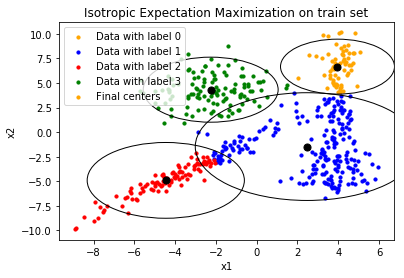

In [72]:
moyennes, variances, pi, classes, vraissemblance = isotropicEM(x)

print("La log-vraissemblance finale vaut {}".format(vraissemblance))
print("\n Les moyennes finales valent: \n {}".format(moyennes))
print("\n Les variances finales valent: \n {}".format(np.array(variances)))
print("\n Les pi finaux valent: \n {}".format(pi))


#On plot les x_{i}
a = plt.scatter(x[classes == 0][0:,0],\
                x[classes == 0][0:,1], color="orange", s=10)

b = plt.scatter(x[classes == 1][0:,0],\
                x[classes == 1][0:,1], color="blue", s=10)

c = plt.scatter(x[classes == 2][0:,0],\
                x[classes == 2][0:,1], color="red", s=10)

d = plt.scatter(x[classes == 3][0:,0],\
                x[classes == 3][0:,1], color="green", s=10)


ma = plt.scatter(moyennes[0:,0], moyennes[0:,1], color="black", s=50)

plt.title("Isotropic Expectation Maximization on train set")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend((a,b, c, d, a), ('Data with label 0','Data with label 1', 'Data with label 2', \
                  'Data with label 3', 'Final centers'), loc="upper left")


#On plot les ellipses qui correspondent à 90% de la masse de la gaussienne associée à chaque classe
ell2(moyennes[0], variances[0][0,0])
ell2(moyennes[1], variances[1][0,0])
ell2(moyennes[2], variances[2][0,0])
ell2(moyennes[3], variances[3][0,0])

plt.show()
plt.close()

La log-vraissemblance finale vaut -2692.807013657316


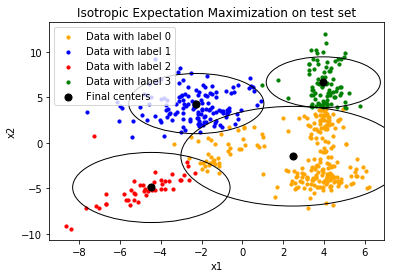

In [77]:
n, p = xtest.shape
#On estime les paramètres sur le train set
moyennes, variances, pi, classes, vraissemblance = isotropicEM(x)


#On calcule les probabilités conditionnalles d'être dans une classe en fonction des paramètres appris
t = np.zeros((n,k))

for j in range(k):
    t[0:, j] = pi[j]*sct.multivariate_normal.pdf(xtest, moyennes[j], variances[j])

sommet = np.sum(t, axis=1).reshape(n,1)
t = t/sommet

classes = np.argmax(t, axis=1)

#On calcule la log-vraissemblance sur l'échantillon de test:
vraissemblance = np.sum(np.log(np.dot(pi.transpose(),\
                         np.array([sct.multivariate_normal.pdf(xtest, moyennes[j], variances[j]) for j in range(k)]))))
print("La log-vraissemblance finale vaut {}".format(vraissemblance))

a = plt.scatter(xtest[classes == 0][0:,0],\
                xtest[classes == 0][0:,1], color="orange", s=10)

b = plt.scatter(xtest[classes == 1][0:,0],\
                xtest[classes == 1][0:,1], color="blue", s=10)

c = plt.scatter(xtest[classes == 2][0:,0],\
                xtest[classes == 2][0:,1], color="red", s=10)
d = plt.scatter(xtest[classes == 3][0:,0],\
                xtest[classes == 3][0:,1], color="green", s=10)


ma = plt.scatter(moyennes[0:,0], moyennes[0:,1], color="black", s=50)

plt.title("Isotropic Expectation Maximization on test set")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend((a,b, c, d, ma), ('Data with label 0','Data with label 1', 'Data with label 2', \
                  'Data with label 3', 'Final centers'), loc="upper left")


ell2(moyennes[3], variances[3][0,0])
ell2(moyennes[2], variances[2][0,0])
ell2(moyennes[1], variances[1][0,0])
ell2(moyennes[0], variances[0][0,0])

plt.show()
plt.close()

## Expectation Maximization

In [74]:
def EM(x):
    n, p = x.shape
    #On initialise l'EM à partir des résultats des K-means
    moyennes, classes, distortions, depart = kmeans(x,k)

    
    pi = np.array([sum(classes == i)/n for i in range(k)])#On initialise les pi
    
    #On intialise les variances
    variances = [np.cov(x[np.array(classes) == i,0], x[np.array(classes) == i,1]) for i in range(k)]
    
    #On calculera la log-vraissemblance à chaque itération
    v1 = np.sum(np.log(np.dot(pi.transpose(),\
                             np.array([sct.multivariate_normal.pdf(x, moyennes[j], variances[j]) for j in range(k)]))))
    v2=0


    while abs(v1-v2) > 1e-2: #On s'arrête quand la vraissemblance n'évolue plus assez
        v2 = v1
        
        #On calcul les proba conditionnelles que x_{i} soit dans une classe, sachant les paramètres actuels
        t = np.zeros((n,k))
        for j in range(k):
            t[0:, j] = pi[j]*sct.multivariate_normal.pdf(x, moyennes[j], variances[j])
        sommet = np.sum(t, axis=1).reshape(n,1)
        t = t/sommet

        #On met à jour les pi
        pi = np.sum(t, axis=0)/n
        
        #On met les moyennes à jour
        moyennes = np.array([np.sum(x*t[0:,j].reshape(n,1)/(n*pi[j]), axis=0) for j in range(k)])


        #On met les variances à jour
        for j in range(k):
            for i in range(n):
                variances[j] += t[i,j]*np.dot((x[i] - moyennes[j]).reshape(2,1), (x[i] - moyennes[j]).reshape(1,2))
            variances[j] /= n*pi[j]

        v1 = np.sum(np.log(np.dot(pi.transpose(),\
                             np.array([sct.multivariate_normal.pdf(x, moyennes[j], variances[j]) for j in range(k)]))))
    
    
    #On calcule les t avec les pi, variances et moyennes finales obtenues
    t = np.zeros((n,k)) 
    for j in range(k):
        t[0:, j] = pi[j]*sct.multivariate_normal.pdf(x, moyennes[j], variances[j])
    sommet = np.sum(t, axis=1).reshape(n,1)
    t = t/sommet
    

    #On calcule les classes finales
    classes = np.argmax(t, axis=1)
    
    return moyennes, variances, pi, classes, v1

La log-vraissemblance finale vaut -2327.751476531757

 Les moyennes finales valent: 
 [[-3.05872649 -3.53148668]
 [-2.03332349  4.1724779 ]
 [ 3.79953368 -3.77009321]
 [ 3.98140089  3.84046772]]

 Les variances finales valent: 
 [[[  6.30098599   6.10752798]
  [  6.10752798   6.23975889]]

 [[  2.93190344   0.20879471]
  [  0.20879471   2.78093681]]

 [[  0.92127955   0.05638548]
  [  0.05638548   1.94668504]]

 [[  0.20992041   0.27791764]
  [  0.27791764  12.05440828]]]

 Les pi finaux valent: 
 [ 0.30569948  0.2516223   0.18583125  0.25684696]


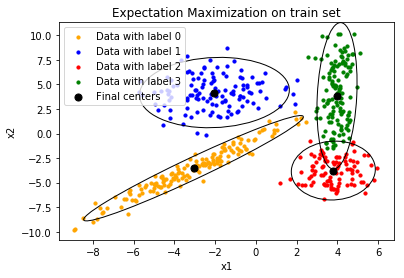

In [75]:
moyennes, variances, pi, classes, vraissemblance = EM(x)

print("La log-vraissemblance finale vaut {}".format(vraissemblance))
print("\n Les moyennes finales valent: \n {}".format(moyennes))
print("\n Les variances finales valent: \n {}".format(np.array(variances)))
print("\n Les pi finaux valent: \n {}".format(pi))

a = plt.scatter(x[classes == 0][0:,0],\
                x[classes == 0][0:,1], color="orange", s=10)

b = plt.scatter(x[classes == 1][0:,0],\
                x[classes == 1][0:,1], color="blue", s=10)

c = plt.scatter(x[classes == 2][0:,0],\
                x[classes == 2][0:,1], color="red", s=10)

d = plt.scatter(x[classes == 3][0:,0],\
                x[classes == 3][0:,1], color="green", s=10)

ma = plt.scatter(moyennes[0:,0], moyennes[0:,1], color="black", s=50)

plt.title("Expectation Maximization on train set")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend((a,b, c, d, ma), ('Data with label 0','Data with label 1', 'Data with label 2', \
                  'Data with label 3', 'Final centers'), loc="upper left")

#On plot les ellipses qui correspondent à 90% de la masse de chaque gaussienne.
ell(variances[0], moyennes[0])
ell(variances[1], moyennes[1])
ell(variances[2], moyennes[2])
ell(variances[3], moyennes[3])

plt.show()
plt.close()

La log-vraissemblance finale vaut: -2409.0537800863067


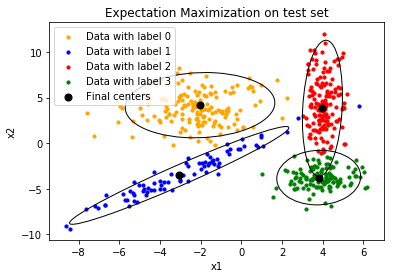

In [76]:
n, p = xtest.shape
t = np.zeros((n,k))

#On estime les paramètres sur le train set
moyennes, variances, pi, classes, vraissemblance = EM(x)

#On calcule les probabilités conditionnalles d'être dans une classe en fonction des paramètres appris
for j in range(k):
    t[0:, j] = pi[j]*sct.multivariate_normal.pdf(xtest, moyennes[j], variances[j])
sommet = np.sum(t, axis=1).reshape(n,1)
t = t/sommet

classes = np.argmax(t, axis=1)

#On calcule la log-vraissemblance sur l'échantillon de test:
vraissemblance = np.sum(np.log(np.dot(pi.transpose(),\
                         np.array([sct.multivariate_normal.pdf(xtest, moyennes[j], variances[j]) for j in range(k)]))))

print("La log-vraissemblance finale vaut: {}".format(vraissemblance))

a = plt.scatter(xtest[classes == 0][0:,0],\
                xtest[classes == 0][0:,1], color="orange", s=10)

b = plt.scatter(xtest[classes == 1][0:,0],\
                xtest[classes == 1][0:,1], color="blue", s=10)

c = plt.scatter(xtest[classes == 2][0:,0],\
                xtest[classes == 2][0:,1], color="red", s=10)

d = plt.scatter(xtest[classes == 3][0:,0],\
                xtest[classes == 3][0:,1], color="green", s=10)

ma = plt.scatter(moyennes[0:,0], moyennes[0:,1], color="black", s=50)


plt.title("Expectation Maximization on test set")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend((a,b, c, d, ma), ('Data with label 0','Data with label 1', 'Data with label 2', \
                  'Data with label 3', 'Final centers'), loc="upper left")


#On plot les ellipses qui correspondent à 90% de la masse de chaque gaussienne.
ell(variances[0], moyennes[0])
ell(variances[1], moyennes[1])
ell(variances[2], moyennes[2])
ell(variances[3], moyennes[3])

plt.show()
plt.close()